# U-Net nose live

We want to see the output of our model on live images from a camera.

In [1]:
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
from  torchvision.transforms import ToTensor,Resize, Normalize
from tqdm import tqdm
from torch import optim

import ipywidgets as widgets
import threading
from ipywidgets import Label, HTML, HBox, Image, VBox, Box, HBox
from ipyevents import Event 
from IPython.display import display

from multiClassUNetDataset import MultiClassUNetDataset
from unet import Unet
from camera import USBCamera, bgr8_to_jpeg
from trackingProject import TrackingProject
from unetGUI import LabelFromCameraGUI

In [2]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")
dataset = MultiClassUNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinates_dir=project.coordinates_dir)

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [3]:
len(dataset)

433

In [4]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Training on device {}".format(device))

Training on device cuda


## Model

In [5]:
model = Unet(in_channels=3,out_channels=len(project.object_list)).to(device)
fn=project.model_fn
model.load_state_dict(torch.load(fn,map_location=device))

<All keys matched successfully>

Get the camera

In [6]:
camera = USBCamera(width=640, height=480)

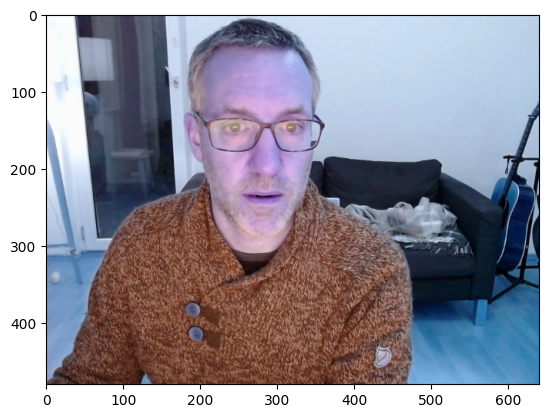

In [7]:
image = camera.read()
plt.imshow(image)

In [8]:
imgWidget = Image(format='jpeg')
imgWidget.value = bgr8_to_jpeg(image)
display(imgWidget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [9]:
def process_image(image):
    input = torch.tensor(image).to(device).permute(2,0,1).unsqueeze(0).float()/255.0
    output = torch.sigmoid(model(input))
    output = (output>0.5).float()
    output = output[0,:].to("cpu").detach().numpy()
    output.shape

    for i in range(output.shape[0]):
        idx=(output[i]==1.0)
        for c in range(3):
            image[idx,c]=project.object_colors[i][c]
        
    return image, output

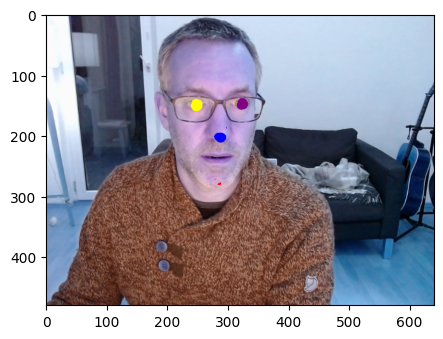

In [10]:
labelImage,output = process_image(image.copy())
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(labelImage)

In [11]:
gui = LabelFromCameraGUI(camera,project,dataset,model,device)

In [15]:
len(dataset)

470

In [16]:
dataset.create_training_validation_dataset(train_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_images",
                                           train_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_masks",
                                           train_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/train_coordinates",
                                               
                                           val_images_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_images",
                                           val_masks_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_masks",
                                           val_coordinates_dir = "/home/kevin/Documents/trackingProjects/faceTrack/dataset/val_coordinates",
                                           test_size=0.15)

Length of training set: 399
Length of validation set: 71
Copying files to training and validation directories
